In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            %cd /home/tf-nlp/nlp/sih2022/OilPrice/

/home/tf-nlp/nlp/sih2022/OilPrice


# Forecasting Natural Gas International Prices using advanced Time-Series Techniques (for next 2.5 years)
### Problem Statement Holder <br> Gas Authority of India Ltd (GAIL) <br> PSID: SK793

<br>
<b>Author:</b> Neeraj Auchar (Team Leader)
<br>
<b>Date created:</b> Jan 27, 2022
<br>
<b>Last modified:</b> March 21, 2022
<br>
<b>Description:</b>
Forecast NATURAL GAS PRICE in international market for coming years. The system to be developed should take data input in MS Excel (CSV) format and provide the output with time-stamp. In this note book we have made an attempt to forecasting natural gas prices for next 2.5 years through various deep learning techniques 

In [ ]:
import os
import datetime
import forcast_multi
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import seaborn as sns
from tsaug.visualization import plot
import tensorflow as tf
from tensorflow import keras
import pandas as pd, numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, Reshape, Lambda
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### <strong>Methodology</strong>
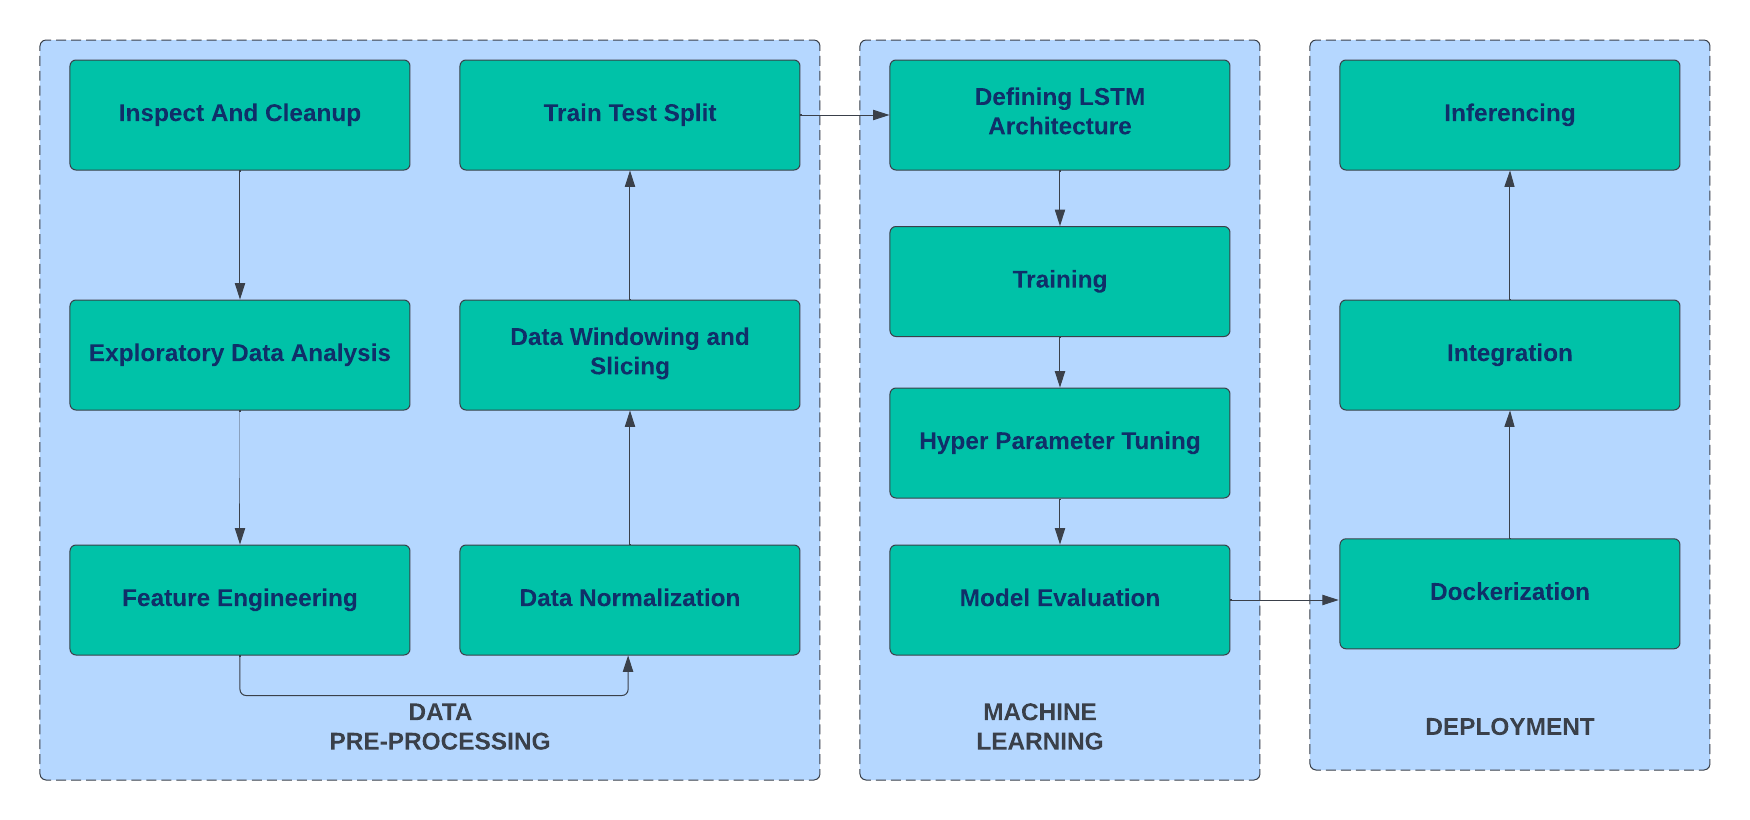

#### Loading data Cleaning and Inspection of the Dataset 
Smoothing using Rolling mean for Multi Step output because our intrest lies in the trend more than price for long sequence 

In [ ]:
csv_path= "data/dataset.csv"
df = pd.read_csv(csv_path,parse_dates=["Date"],infer_datetime_format=True)
df = df.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'value'})
df['value'] = df['value'].rolling(10,min_periods=1).mean()
df = df[df['value'].notna()]

#### Visualize the data

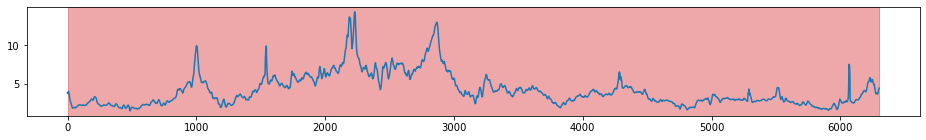

In [ ]:
plot(df['value'].to_numpy(),np.array(range(len(df))))
plt.show()

#### Data Augmentation
Deep networks need large amount of training data to achieve good performance. To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

tsaug is a Python package that we are using for  augmentation of time series. There are 15 augmentation methods implemented in tsaug. They include methods that mimic common image augmentation methods, e.g. cropping, magnifying, flipping (reversing timeline), adding noises, as well as methods that are designed specifically for time series data, e.g. time warping, sidetracking, superposing trends, etc.

In [ ]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (
TimeWarp() * 5  
+ Quantize(n_levels=[10, 20, 30])
+ Drift(max_drift=(0.1, 0.5)) @ 0.8
+ Reverse() @ 0.5
)

(5, 6302) (5, 6302)


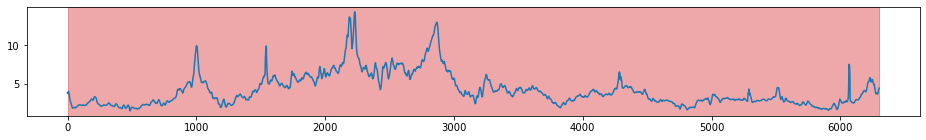

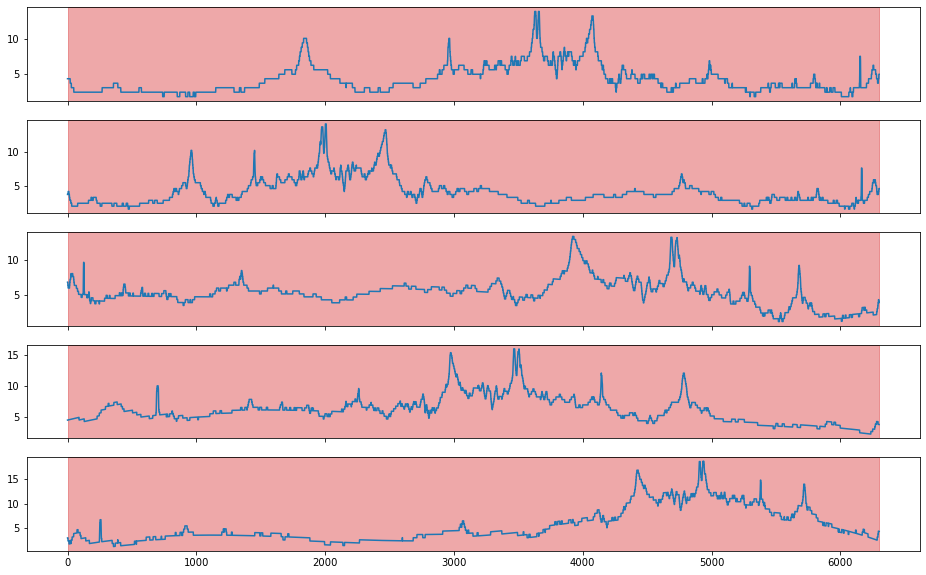

In [ ]:
X_aug, Y_aug = my_augmenter.augment(df['value'].to_numpy(),np.array(range(len(df))))
print(X_aug.shape, Y_aug.shape)
plot(df['value'].to_numpy(),np.array(range(len(df))))
plot(X_aug, Y_aug)
plt.show()

In [ ]:
dfs = []
for i,j in zip(X_aug, Y_aug):
    temp = pd.DataFrame()
    temp["Date"] = df["Date"]
    if(j[0] > j[-1]):
        temp['value'] = np.flip(i)
    else:
        temp['value'] = i
    dfs.append(temp)

#### Slicing, Downsampling and Data Windowing

We have used a downsampling technique in which the data is downsampled month wise (assuming 30 days a month). Then we slice the data through windowing and generate training samples compatible with model input.

In [ ]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = [], []
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence.loc[i:lag_end], sequence.loc[lag_end:forecast_end,'value']
        seq_x = np.expand_dims(seq_x.to_numpy(),axis=0)
        seq_y = np.expand_dims(seq_y.to_numpy().reshape(-1,1),axis=0)
        if(seq_x.shape == (1,60, 5) and seq_y.shape == (1,30, 1)):
            X.append(seq_x)
            y.append(seq_y)
    X = np.concatenate(X,axis=0)
    y = np.concatenate(y,axis=0)
    return X,y

In [ ]:
LOOK_BACK = 59
FORECAST_RANGE = 29
def make_data(df,look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE):
    df = df.reset_index(drop=True)
    df['key'] = np.nan
    for i in range(30):
        df.loc[i::30,'key'] = str(i+1)
#     print(df)
    Xt, yt = list(), list()
    for key,i in df.groupby('key'):
        i = i.drop(['key'], axis = 1)
        i = i.reset_index(drop=True)
#         print(i)
        x, y = split_sequence(i,look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)       
        Xt.append(x)
        yt.append(y)   
    X = np.concatenate(Xt,axis=0)
    Y = np.concatenate(yt,axis=0)    
    print(X.shape, Y.shape)
    return(X, Y)

#### Cyclical features encoding, it’s about time!!
<ul>
<li>Technique to transform features such as time, weeks, months preserve their cyclical significance.</li>
<li>Perform a sine and cosine transformation of the feature for encoding feature with cyclic nature.</li>
</ul>

In [ ]:
def add_time_enc(df):
    date_time = df.pop('Date')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    month = 30*86400.0
    year = 12*month
    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(df)
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    train_df = df[:-2700]
    # val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[-2700:]
    num_features = df.shape[1]
    print(len(train_df), len(test_df), len(train_df)+len(test_df)==n)
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    # val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    return(train_df, test_df)

In [ ]:
dfs = []
for i,j in zip(X_aug, Y_aug):
    temp = pd.DataFrame()
    temp["Date"] = df["Date"]
    if(j[0] > j[-1]):
        temp['value'] = np.flip(i)
    else:
        temp['value'] = i
    dfs.append(temp)

#### Merge the new Agumented timeseries 
We merge the new agumented time series data to form the training set 

***Note: Agumentation is only applied to the training set not the testing or validation set***

In [ ]:
mergedDF = pd.DataFrame()
for i in dfs:
    print(i.shape)
    train_df, test_df = add_time_enc(i)
    print(train_df.shape, test_df.shape)
    mergedDF = mergedDF.append(train_df)
mergedDF = mergedDF.reset_index(drop=True)

(6302, 2)
3602 2700 True
(3602, 5) (2700, 5)
(6302, 2)
3602 2700 True
(3602, 5) (2700, 5)
(6302, 2)
3602 2700 True
(3602, 5) (2700, 5)
(6302, 2)
3602 2700 True
(3602, 5) (2700, 5)
(6302, 2)
3602 2700 True
(3602, 5) (2700, 5)


In [ ]:
date_time = df.pop('Date')

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [ ]:
month = 30*86400.0
year = 12*month

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[:-2700]
test_df = df[-2700:]
num_features = df.shape[1]
len(train_df), len(test_df), len(train_df)+len(test_df)==n

(3602, 2700, True)

#### Data Normalization 

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
mergedDF = mergedDF.append(train_df)
mergedDF = mergedDF.reset_index(drop=True)
mergedDF.shape

(21612, 5)

In [ ]:
X_train, y_train = make_data(train_df,look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = make_data(test_df,look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)

(962, 60, 5) (962, 30, 1)
(60, 60, 5) (60, 30, 1)


### The input to the architecture will be the downsampled data for past 60 months or 5 year and the output from the architecture will be the forcasted data for next 2.5 years or 30 months

In [ ]:
OUT_STEPS = 30
ipw = 30*2

In [ ]:
num_features = train_df.shape[1]
num_features

5

In [ ]:
feedback_model = forcast_multi.FeedBack(units=ipw, out_steps=OUT_STEPS,num_features=5)

#### Common function to compile, add callbacks and train model
<ul>
<li>Loss function: MSE (mean Squred Error)</li>
<li>Callbacks: Early Stopping, Loss Moniter</li>
<li>Optimizer: Adam</li>
<li>Evulation metrics: Mean Absolute Error</li>
<li>Number of Epoch: 100&nbsp;</li>
</ul>

In [ ]:
def compile_and_fit(model, X,y, patience=10,MAX_EPOCHS = 100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(X,y, epochs=MAX_EPOCHS,
                      validation_split=0.15,
                      callbacks=[early_stopping])
    return history

In [ ]:
multi_val_performance, multi_performance = {}, {}

#### Deep Learning Architecture
<ul>
<li>Problem can be posed as a regression problem since the output is continuous</li>
<li>Given Natural Gas prices since 1997 till 2021 forecast the trend of the natural gas prices for next 5 years</li>
<li>We are dealing with regression of sequences, LSTM (Long Short Term Memory) Architecture from RNN (Recurrent Neural Networks) is considered to be the most successful and also the most popular approach to deal with sequential or time dependent data.</li>
<li>One of the appeals of RNNs is the idea that they are able to connect previous information to the present input. LSTM are a special kind of RNN, capable of learning long-term dependencies in data. LSTM offers a special memory unit to retain past information and do future computation simultaneously</li>
<li>LSTM&rsquo;s have the form of a chain of repeating modules of neural network.</li>
<li>This architecture can over 3 problems:
<ul>
<li>Temporal dependency problem</li>
<li>Sequential Data</li>
<li>Scalable</li>
</ul>
</li>
</ul>

#### Autoregressive LSTM Architecture
<ul>
<li>In traditional LSTM architectures the entire output sequence is predicted in one shot. In autoregressive model the models decompose the output sequence into individual time steps therefore the prediction at nth step is dependent on (n-1)th prediction and context/hidden vector from the past LSTM unit</li>
<li>The input to the architecture will be same as that of the multistep LSTM (initial 30*6 values) while generating output sequence the first output will be fed to the next LSTM unit along with the hidden vector and this will be repeated till we reach the end of the output sequence</li>
<li>This approach overcomes scalability challenges present in past architectures i.e they fail to forecast long sequences as in our case 2021 to 2026 where traditional approach would become impractically slow to train.</li>
</ul>


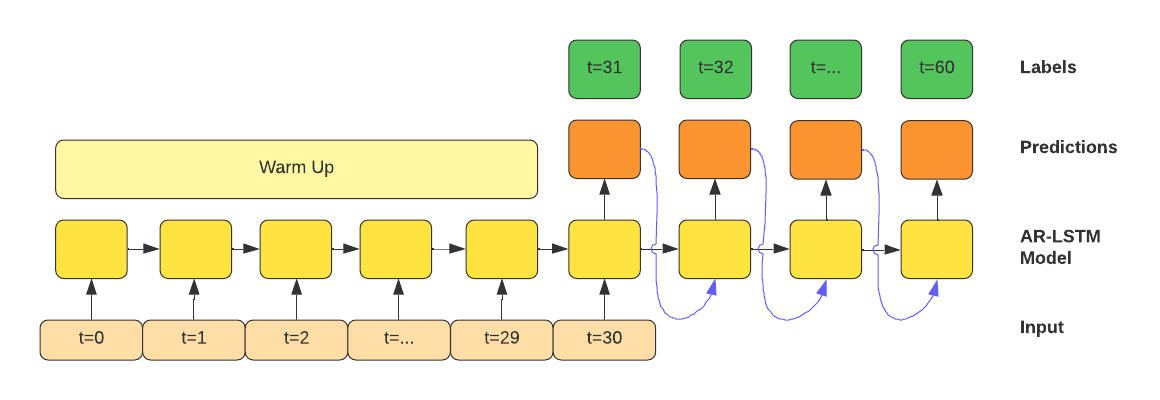


In [ ]:
history_feedback_model = compile_and_fit(feedback_model, X_train, y_train,MAX_EPOCHS=200)

Epoch 1/200
504/504 [==============================] - 99s 182ms/step - loss: 0.6483 - mean_absolute_error: 0.5798 - val_loss: 0.4805 - val_mean_absolute_error: 0.4763
Epoch 2/200
504/504 [==============================] - 91s 180ms/step - loss: 0.3753 - mean_absolute_error: 0.4222 - val_loss: 0.2849 - val_mean_absolute_error: 0.3713
Epoch 3/200
504/504 [==============================] - 91s 180ms/step - loss: 0.2331 - mean_absolute_error: 0.3365 - val_loss: 0.1874 - val_mean_absolute_error: 0.3030
Epoch 4/200
504/504 [==============================] - 91s 180ms/step - loss: 0.1733 - mean_absolute_error: 0.2895 - val_loss: 0.1597 - val_mean_absolute_error: 0.2789
Epoch 5/200
504/504 [==============================] - 91s 181ms/step - loss: 0.1411 - mean_absolute_error: 0.2626 - val_loss: 0.1343 - val_mean_absolute_error: 0.2531
Epoch 6/200
504/504 [==============================] - 91s 181ms/step - loss: 0.1237 - mean_absolute_error: 0.2466 - val_loss: 0.1238 - val_mean_absolute_error:

In [ ]:
feedback_model.save_weights('models30_aug/feedback_model/feedback_model')

In [ ]:
new_feedback_model = forcast_multi.FeedBack(units=ipw, out_steps=OUT_STEPS,num_features=5)
new_feedback_model.load_weights('models30_aug/feedback_model/feedback_model')
new_feedback_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
new_feedback_model.evaluate(X_test, y_test)

2/2 [==============================] - 6s 38ms/step - loss: 0.8705 - mean_absolute_error: 0.7519


[0.8704895377159119, 0.7519116401672363]

In [ ]:
AR_LSTM_Hist = pd.DataFrame(history_feedback_model.history)
AR_LSTM_Hist.to_csv('history_aug/AR_LSTM.csv')
multi_val_performance['AR LSTM'] = new_feedback_model.evaluate(X_train, y_train)
multi_performance['AR LSTM'] = new_feedback_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 38ms/step - loss: 0.8705 - mean_absolute_error: 0.7519


#### Multi Step LSTM 
<ul>
<li>In multi step LSTM input to the architecture will be a downsampled sequence of values (prices) of past 60 Month and the output will also be a sequence of predict values for next 30 months</li>
<li>The output vector from the last LSTM unit is passed to a feed forward neural network with 30 neurons</li>
<li>Each neuron will represent a value form the output sequence of next 30 months.</li>
<li>Which will be mapped against the ground truth to compute error</li>
</ul>


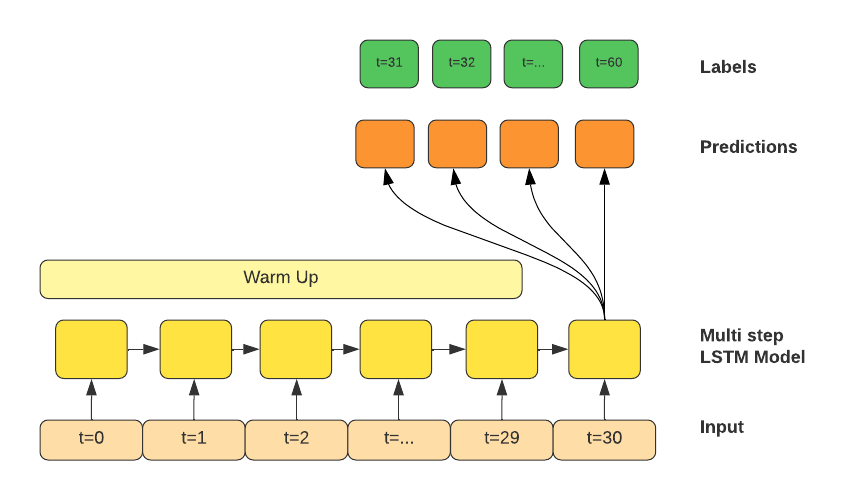

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(int(ipw), return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])
# loss: 0.8906 - mean_absolute_error: 0.7982 - val_loss: 0.8883 - val_mean_absolute_error: 0.7967
history_multi_lstm_model = compile_and_fit(multi_lstm_model, X_train, y_train,MAX_EPOCHS=200)

Epoch 1/200
504/504 [==============================] - 10s 14ms/step - loss: 0.6709 - mean_absolute_error: 0.5912 - val_loss: 0.4815 - val_mean_absolute_error: 0.4773
Epoch 2/200
504/504 [==============================] - 6s 12ms/step - loss: 0.3943 - mean_absolute_error: 0.4278 - val_loss: 0.3320 - val_mean_absolute_error: 0.3947
Epoch 3/200
504/504 [==============================] - 6s 12ms/step - loss: 0.2926 - mean_absolute_error: 0.3704 - val_loss: 0.2571 - val_mean_absolute_error: 0.3432
Epoch 4/200
504/504 [==============================] - 6s 12ms/step - loss: 0.2301 - mean_absolute_error: 0.3294 - val_loss: 0.2070 - val_mean_absolute_error: 0.3125
Epoch 5/200
504/504 [==============================] - 6s 12ms/step - loss: 0.1980 - mean_absolute_error: 0.3045 - val_loss: 0.1732 - val_mean_absolute_error: 0.2839
Epoch 6/200
504/504 [==============================] - 6s 12ms/step - loss: 0.1627 - mean_absolute_error: 0.2767 - val_loss: 0.1545 - val_mean_absolute_error: 0.2685
Epo

504/504 [==============================] - 6s 13ms/step - loss: 0.0593 - mean_absolute_error: 0.1662 - val_loss: 0.0603 - val_mean_absolute_error: 0.1688
Epoch 100/200
504/504 [==============================] - 6s 13ms/step - loss: 0.0591 - mean_absolute_error: 0.1659 - val_loss: 0.0598 - val_mean_absolute_error: 0.1689
Epoch 101/200
504/504 [==============================] - 6s 13ms/step - loss: 0.0689 - mean_absolute_error: 0.1757 - val_loss: 0.2475 - val_mean_absolute_error: 0.3067
Epoch 102/200
504/504 [==============================] - 7s 13ms/step - loss: 0.0796 - mean_absolute_error: 0.1921 - val_loss: 0.0641 - val_mean_absolute_error: 0.1756
Epoch 103/200
504/504 [==============================] - 7s 13ms/step - loss: 0.0609 - mean_absolute_error: 0.1688 - val_loss: 0.0617 - val_mean_absolute_error: 0.1713
Epoch 104/200
504/504 [==============================] - 6s 13ms/step - loss: 0.0592 - mean_absolute_error: 0.1661 - val_loss: 0.0606 - val_mean_absolute_error: 0.1694
Epoch 

In [ ]:
# multi_lstm_model.save('models30_aug/LSTM.h5')
# LSTM_Hist = pd.DataFrame(history_multi_lstm_model.history)
# LSTM_Hist.to_csv('history_aug/LSTM.csv')
multi_lstm_model = tf.keras.models.load_model('models30_aug/LSTM.h5')
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(X_train, y_train)
multi_performance['LSTM'] = multi_lstm_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.9802 - mean_absolute_error: 0.8203


In [ ]:
multi_lstm_model = tf.keras.models.load_model('models30_aug/LSTM.h5')
multi_lstm_model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 7ms/step - loss: 0.9802 - mean_absolute_error: 0.8203


[0.9801797866821289, 0.820253312587738]

#### Multi setp Convolution neural network
A convolution layer also takes multiple time steps as input to each prediction. We can just replace the LSTM layer in past architecture with Convolution Layer

In [ ]:
CONV_WIDTH = 15
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history_multi_conv_model = compile_and_fit(multi_conv_model, X_train, y_train,MAX_EPOCHS=200)

In [ ]:
multi_conv_model.save('models30_aug/Conv.h5')
Conv_Hist = pd.DataFrame(history_multi_conv_model.history)
Conv_Hist.to_csv('history_aug/Conv.csv')
multi_val_performance['Conv'] = multi_conv_model.evaluate(X_train, y_train)
multi_performance['Conv'] = multi_conv_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 0.3204 - mean_absolute_error: 0.4390


In [ ]:
multi_conv_model.save('models30_aug/Conv.h5')
multi_conv_model = tf.keras.models.load_model('models30_aug/Conv.h5')
multi_conv_model.evaluate(X_test, y_test)

2/2 [==============================] - 7s 13ms/step - loss: 0.3204 - mean_absolute_error: 0.4390


[0.32038068771362305, 0.4390217661857605]

#### Time2Vec LSTM
<ul>
<li>Time is an important feature in forecasting involving events that occur synchronously and/or asynchronously</li>
<li>To effectively consume time dependent information in this approach we have provided a model-agnostic vector representation for time called Time2Vec</li>
<li>This can be easily integrated with our last LSTM architecture and improve its performances.</li>
<li>Time2vec has 3 important properties
<ul>
<li>Captures both periodic and non-periodic ![Time2VecMulti.png](attachment:Time2VecMulti.png)patterns</li>
<li>It is invariant to time rescaling (can adapt to any scale of time measurement e.g., week, days, month)</li>
<li>being simple enough so it can be combined with many models e.g. LSTM, CNN, Transformers</li>
</ul>
</li>
</ul>

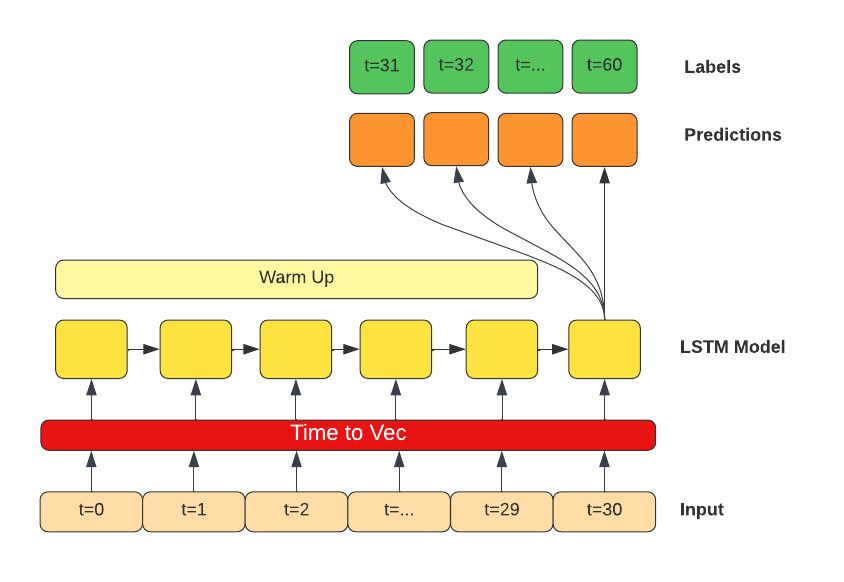

In [ ]:
from tensorflow.keras.layers import *
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)
### DEFINE MODEL STRUCTURES ###
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def T2V_NN(dim,OUT_STEPS):
    inp = Input(shape=(dim,5))
    x = T2V(16)(inp)
    x = tf.keras.layers.Concatenate(axis=-1)([x, inp])
    x = LSTM(int(ipw*0.5), activation='relu')(x)
    x = Dense(OUT_STEPS,kernel_initializer=tf.initializers.zeros())(x)
    x = tf.keras.layers.Reshape([OUT_STEPS, 1])(x)
    m = Model(inp, x)
    return m

In [ ]:
modelT2V = T2V_NN(dim=ipw,OUT_STEPS=OUT_STEPS)
history_multi_conv_model = compile_and_fit(modelT2V, X_train, y_train,MAX_EPOCHS=200)
modelT2V.save_weights('models30_aug/modelT2V/modelT2V')
modelT2V.load_weights('models30_aug/modelT2V/modelT2V')
modelT2V.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
T2V_Hist = pd.DataFrame(history_multi_conv_model.history)
T2V_Hist.to_csv('history_aug/T2V.csv')
multi_val_performance['T2V'] = modelT2V.evaluate(X_train, y_train)
multi_performance['T2V'] = modelT2V.evaluate(X_test, y_test)
# 31/31 [==============================] - 1s 28ms/step - loss: 0.0445 - mean_absolute_error: 0.1497
# 2/2 [==============================] - 0s 32ms/step - loss: 3.0857 - mean_absolute_error: 1.5129

2/2 [==============================] - 0s 28ms/step - loss: 0.8032 - mean_absolute_error: 0.7161


#### T2V Transfomer 
<ul>
<li>Transformers are a state-of-the-art solution to Natural Language Processing (NLP) tasks. They are based on the Multihead-Self-Attention (MSA) mechanism, in which each token along the input sequence is compared to every other token in order to gather information and learn dynamic contextual information.</li>
<li>Because they do not analyze their input sequentially, Transformers largely solve the vanishing gradient problem that hinders Recurrent Neural Networks (RNNs) in long-term prediction and where output sequence is long.</li>
<li>Transfomers can also be combined will T2V techniqe that will help the architecture extract seasonal information</li>
</ul>

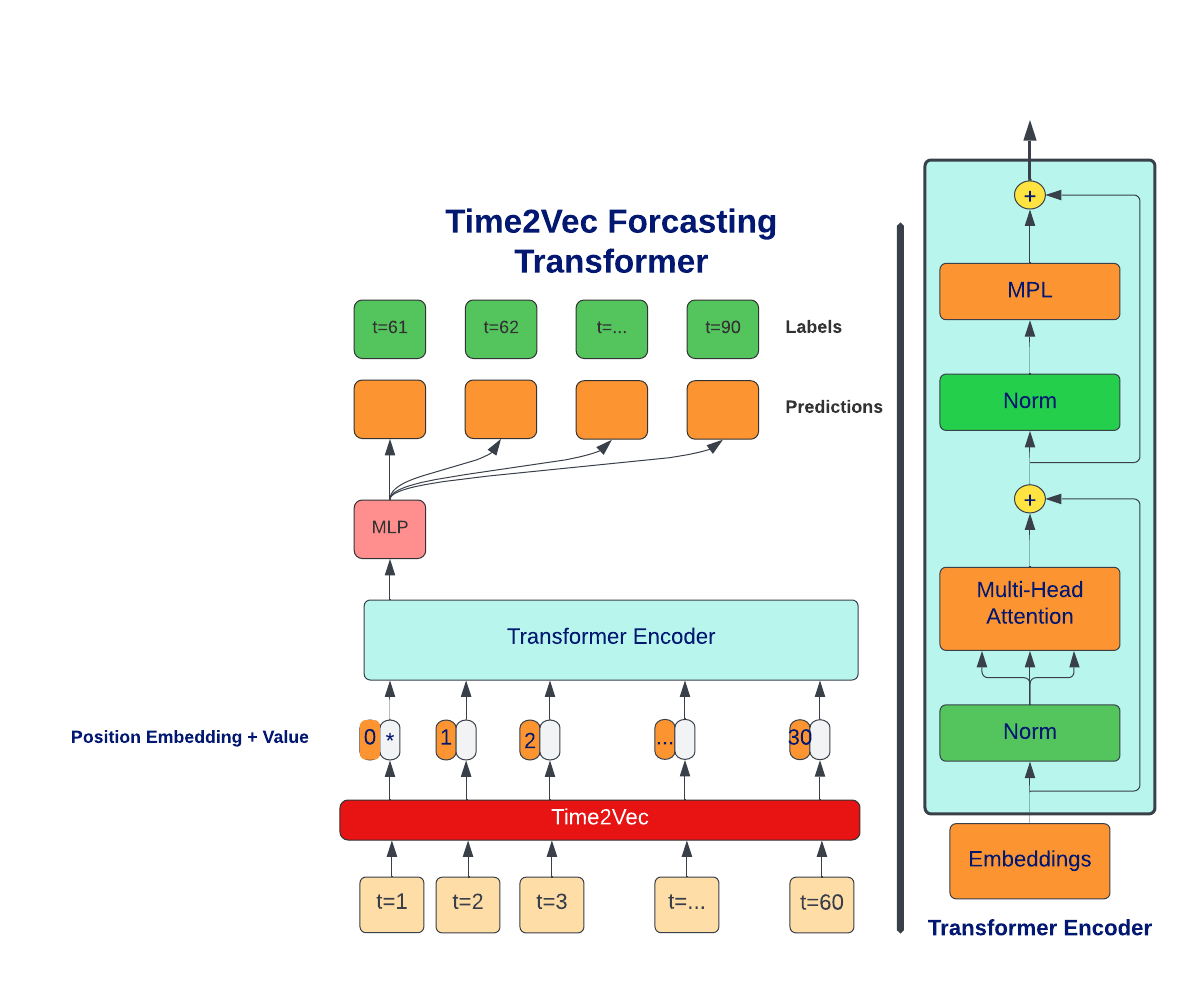

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = keras.Sequential( [layers.Dense(ff_dim, activation = "gelu"), layers.Dense(feat_dim),] )
        self.layernorm1 = layers.BatchNormalization()
        self.layernorm2 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

Adding T2V layer to the above transfomer

In [ ]:
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size = 1):
        super(Time2Vec, self).__init__(trainable = True, name = 'Time2VecLayer')
        self.k = kernel_size

    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name = 'wb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        self.bb = self.add_weight(name = 'bb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        # periodic
        self.wa = self.add_weight(name = 'wa', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        self.ba = self.add_weight(name = 'ba', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)
        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1] * (self.k + 1)))
        return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * (self.k + 1))

In [ ]:
def get_model(input_shape, time2vec_dim = 3):
    inp = Input(input_shape)
    x = inp

    time_embedding = keras.layers.TimeDistributed(Time2Vec(time2vec_dim - 1))(x)
    x = Concatenate(axis = -1)([x, time_embedding])
    x = layers.LayerNormalization(epsilon = 1e-6)(x)

    for k in range(N_BLOCKS):
        x_old = x
        transformer_block = TransformerBlock(EMBED_DIM, input_shape[-1] + ( input_shape[-1] * time2vec_dim), N_HEADS, FF_DIM, DROPUT_RATE)
        x = transformer_block(x)
        x = ((1.0 - SKIP_CONNECTION_STRENGTH) * x) + (SKIP_CONNECTION_STRENGTH * x_old)

    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = Dense(OUT_STEPS,kernel_initializer=tf.initializers.zeros())(x)
    x = tf.keras.layers.Reshape([OUT_STEPS, 1])(x)
    out = x
    model = Model(inp, out)
    return model

In [ ]:
TIME_2_VEC_DIM = 8
N_BLOCKS = 3
EMBED_DIM = 16
N_HEADS = 4
DROPUT_RATE = 0.0
FF_DIM = 16
SKIP_CONNECTION_STRENGTH = 0.9
transfomer = get_model(X_train.shape[1:], TIME_2_VEC_DIM)

In [ ]:
history_multi_transfomer_model = compile_and_fit(transfomer, X_train, y_train,MAX_EPOCHS=100)

Epoch 1/100
504/504 [==============================] - 19s 29ms/step - loss: 0.4683 - mean_absolute_error: 0.4887 - val_loss: 0.2771 - val_mean_absolute_error: 0.3753
Epoch 2/100
504/504 [==============================] - 14s 28ms/step - loss: 0.1772 - mean_absolute_error: 0.3033 - val_loss: 0.1471 - val_mean_absolute_error: 0.2742
Epoch 3/100
504/504 [==============================] - 15s 31ms/step - loss: 0.1199 - mean_absolute_error: 0.2509 - val_loss: 0.1177 - val_mean_absolute_error: 0.2497
Epoch 4/100
504/504 [==============================] - 14s 27ms/step - loss: 0.0941 - mean_absolute_error: 0.2244 - val_loss: 0.1015 - val_mean_absolute_error: 0.2333
Epoch 5/100
504/504 [==============================] - 15s 29ms/step - loss: 0.0786 - mean_absolute_error: 0.2065 - val_loss: 0.0895 - val_mean_absolute_error: 0.2173
Epoch 6/100
504/504 [==============================] - 17s 34ms/step - loss: 0.0673 - mean_absolute_error: 0.1929 - val_loss: 0.0735 - val_mean_absolute_error: 0.200

Epoch 50/100
504/504 [==============================] - 17s 34ms/step - loss: 0.0145 - mean_absolute_error: 0.0922 - val_loss: 0.0277 - val_mean_absolute_error: 0.1230
Epoch 51/100
504/504 [==============================] - 17s 33ms/step - loss: 0.0138 - mean_absolute_error: 0.0898 - val_loss: 0.0295 - val_mean_absolute_error: 0.1267
Epoch 52/100
504/504 [==============================] - 17s 33ms/step - loss: 0.0138 - mean_absolute_error: 0.0899 - val_loss: 0.0297 - val_mean_absolute_error: 0.1249


In [ ]:
# transfomer.save_weights('models30_aug/transfomerT2V/transfomerT2V')
# transfomerT2V_Hist = pd.DataFrame(history_multi_transfomer_model.history)
# transfomerT2V_Hist.to_csv('history_aug/transfomerT2V.csv')
transfomer.load_weights('models30_aug/transfomerT2V/transfomerT2V')
transfomer.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
multi_val_performance['transfomerT2V'] = transfomer.evaluate(X_train, y_train)
multi_performance['transfomerT2V'] = transfomer.evaluate(X_test, y_test)
# 31/31 [==============================] - 0s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0316
# 2/2 [==============================] - 0s 17ms/step - loss: 2.7086 - mean_absolute_error: 1.5490

2/2 [==============================] - 0s 14ms/step - loss: 0.4285 - mean_absolute_error: 0.5597


#### Basic Teansformer without T2V

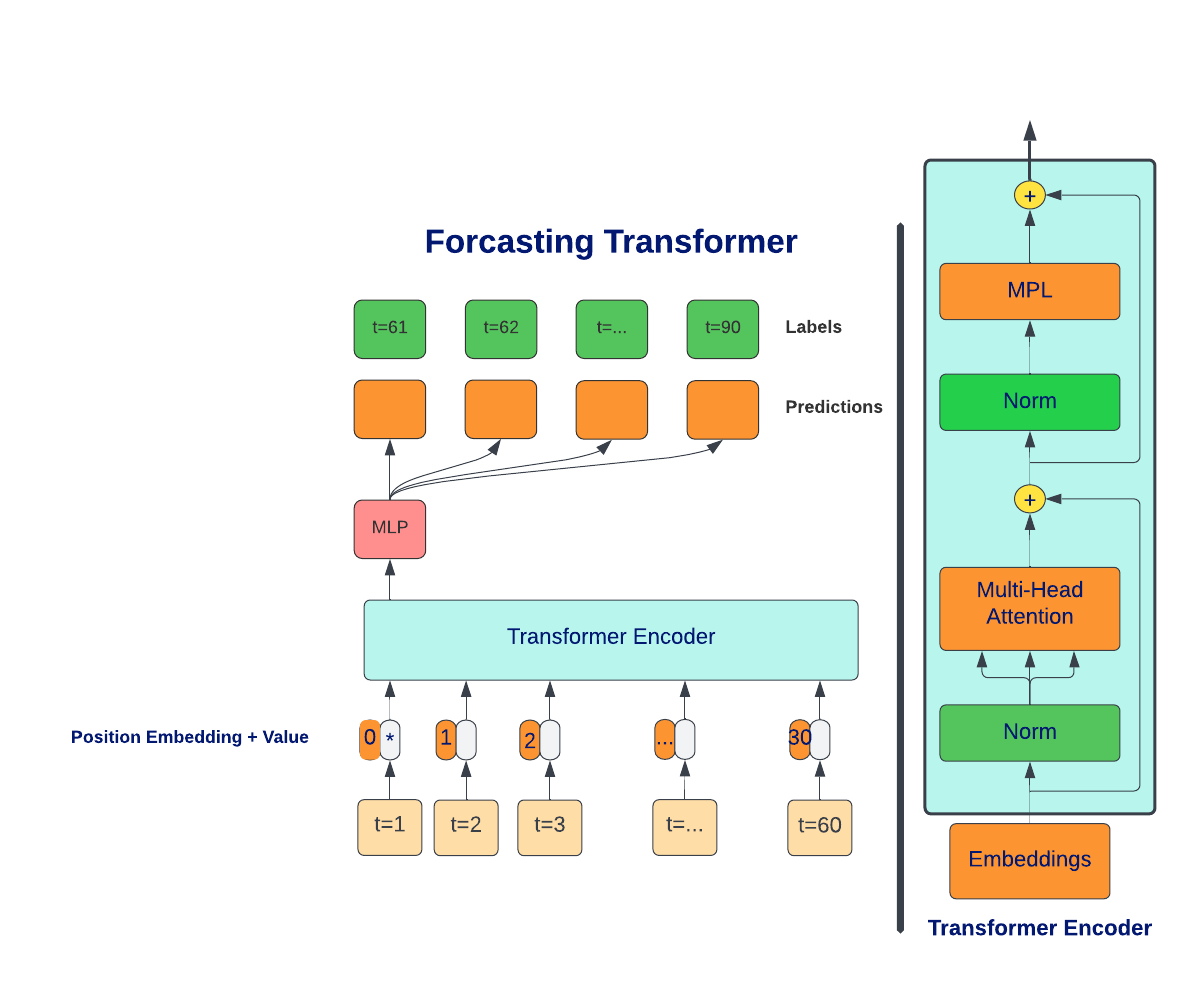

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    x = Dense(OUT_STEPS,kernel_initializer=tf.initializers.zeros())(x)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, 1])(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

basic_transfomer = build_model(
    input_shape,
    head_size=16,
    num_heads=2,
    ff_dim=2,
    num_transformer_blocks=2,
    mlp_units=[16],
    mlp_dropout=0.04,
    dropout=0.025,
)

In [ ]:
history_basic_transfomer = compile_and_fit(basic_transfomer, X_train, y_train,MAX_EPOCHS=200)

Epoch 1/200
26/26 [==============================] - 3s 40ms/step - loss: 1.4209 - mean_absolute_error: 0.9319 - val_loss: 1.2713 - val_mean_absolute_error: 0.8491
Epoch 2/200
26/26 [==============================] - 1s 25ms/step - loss: 0.9505 - mean_absolute_error: 0.7339 - val_loss: 0.8437 - val_mean_absolute_error: 0.6928
Epoch 3/200
26/26 [==============================] - 1s 24ms/step - loss: 0.7720 - mean_absolute_error: 0.6685 - val_loss: 0.8020 - val_mean_absolute_error: 0.6807
Epoch 4/200
26/26 [==============================] - 1s 25ms/step - loss: 0.7410 - mean_absolute_error: 0.6572 - val_loss: 0.7791 - val_mean_absolute_error: 0.6690
Epoch 5/200
26/26 [==============================] - 1s 26ms/step - loss: 0.7229 - mean_absolute_error: 0.6493 - val_loss: 0.7570 - val_mean_absolute_error: 0.6536
Epoch 6/200
26/26 [==============================] - 1s 25ms/step - loss: 0.6975 - mean_absolute_error: 0.6374 - val_loss: 0.7176 - val_mean_absolute_error: 0.6374
Epoch 7/200
26/2

Epoch 51/200
26/26 [==============================] - 1s 23ms/step - loss: 0.1108 - mean_absolute_error: 0.2377 - val_loss: 0.0865 - val_mean_absolute_error: 0.2183
Epoch 52/200
26/26 [==============================] - 1s 23ms/step - loss: 0.0965 - mean_absolute_error: 0.2232 - val_loss: 0.0855 - val_mean_absolute_error: 0.2140
Epoch 53/200
26/26 [==============================] - 1s 22ms/step - loss: 0.1027 - mean_absolute_error: 0.2288 - val_loss: 0.0851 - val_mean_absolute_error: 0.2145
Epoch 54/200
26/26 [==============================] - 1s 22ms/step - loss: 0.0987 - mean_absolute_error: 0.2243 - val_loss: 0.0834 - val_mean_absolute_error: 0.2132
Epoch 55/200
26/26 [==============================] - 1s 23ms/step - loss: 0.1085 - mean_absolute_error: 0.2342 - val_loss: 0.0855 - val_mean_absolute_error: 0.2146
Epoch 56/200
26/26 [==============================] - 1s 22ms/step - loss: 0.1028 - mean_absolute_error: 0.2276 - val_loss: 0.0820 - val_mean_absolute_error: 0.2113
Epoch 57/2

Epoch 101/200
26/26 [==============================] - 1s 23ms/step - loss: 0.1002 - mean_absolute_error: 0.2212 - val_loss: 0.0655 - val_mean_absolute_error: 0.1906
Epoch 102/200
26/26 [==============================] - 1s 22ms/step - loss: 0.0964 - mean_absolute_error: 0.2169 - val_loss: 0.0660 - val_mean_absolute_error: 0.1928
Epoch 103/200
26/26 [==============================] - 1s 24ms/step - loss: 0.0964 - mean_absolute_error: 0.2172 - val_loss: 0.0657 - val_mean_absolute_error: 0.1909
Epoch 104/200
26/26 [==============================] - 1s 24ms/step - loss: 0.0959 - mean_absolute_error: 0.2143 - val_loss: 0.0660 - val_mean_absolute_error: 0.1889
Epoch 105/200
26/26 [==============================] - 1s 24ms/step - loss: 0.0932 - mean_absolute_error: 0.2122 - val_loss: 0.0649 - val_mean_absolute_error: 0.1876
Epoch 106/200
26/26 [==============================] - 1s 24ms/step - loss: 0.0890 - mean_absolute_error: 0.2102 - val_loss: 0.0643 - val_mean_absolute_error: 0.1887
Epoc

In [ ]:
basic_transfomer_Hist = pd.DataFrame(history_multi_transfomer_model.history)
basic_transfomer_Hist.to_csv('history/basic_transfomer.csv')
multi_val_performance['basic_transfomer'] = basic_transfomer.evaluate(X_train, y_train)
multi_performance['basic_transfomer'] = basic_transfomer.evaluate(X_test, y_test)

2/2 [==============================] - 0s 20ms/step - loss: 4.7311 - mean_absolute_error: 2.0967


In [ ]:
import json
json_object1 = json.dumps(multi_val_performance, indent = 4)
json_object2 = json.dumps(multi_performance, indent = 4)

In [ ]:
with open("history_aug/train.json", "w") as outfile:
    json.dump(multi_val_performance, outfile)
with open("history_aug/test.json", "w") as outfile:
    json.dump(multi_performance, outfile)

### Results 🚨

<p><span style="color: #ff6600;"><span style="color: #000000;">As per the performance on latest unseen set the model from best to least can be ranked as&nbsp;</span></span></p>
<ol>
<li><span style="color: #ff6600;"><span style="color: #000000;">CNN 🎉</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">T2V Transformer 🎆</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">T2V LSTM 👏</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">LSTM 🙌</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">AR-LSTM 👍</span></span></li>
</ol>

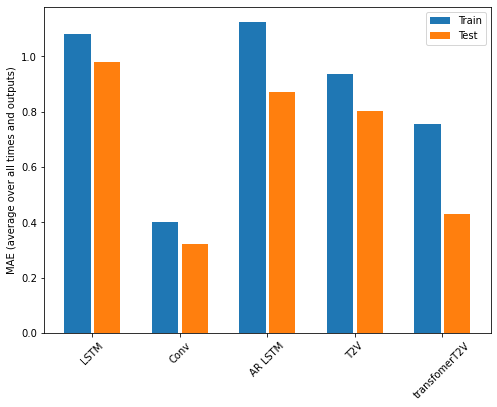

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'loss'
metric_index = transfomer.metrics_names.index('loss')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Train')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

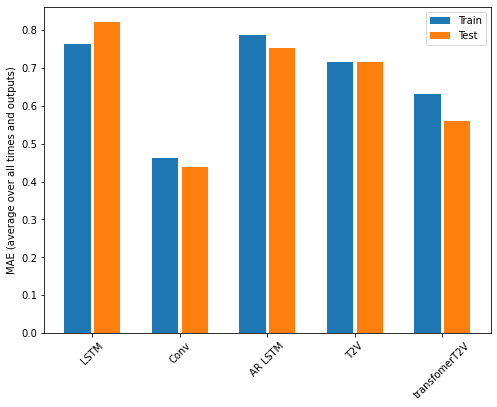

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = transfomer.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Train')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

# Inferencing

In [ ]:
def decode_y(tempY,threshold=2e3):
    main = []
    for i in range(0,len(tempY),2):
        b, a = tempY[i], tempY[i+1]
        b = np.append(b[:,0],np.nan)
        a = np.append(np.nan,a[:,0])
        avg = np.nanmean([a, b], axis=0)
        main.append(avg)
    print(len(main), len(main[0]))
    arr = np.empty((len(main)* main[0].shape[0]))
    arr[:] = np.nan
    for i in range(len(main)):
        arr[i::30] = main[i]
    filtered = filter_signal(arr, threshold=threshold)
    return(filtered)

In [ ]:
tempdf = test_df[-90*30:]
tempdf.shape

(2700, 5)

#### Generate testing samples
<ul>
<li><strong>Input</strong>: 5 years of data (2013 to 2018)</li>
<li><strong>Output</strong>: 2.5 years of forcasted data (2019 to 2022)</li>
</ul>

In [ ]:
tempX, tempY = make_data(tempdf,look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)

In order to get most accurat forcastings with minimal devation from the original signal we have add a signal filter in the forcasting pipeline which will clean and filter the noise from the output time series 

In [ ]:
from numpy.fft import *
def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

30 31
30 31


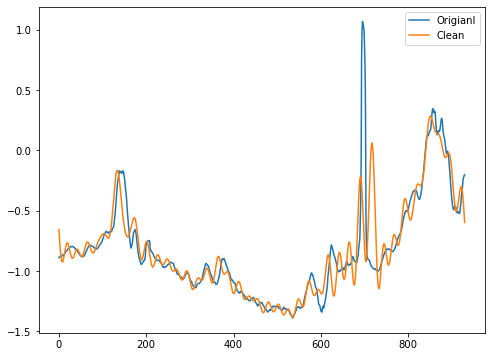

In [ ]:
plt.plot(tempdf['value'][-1*len(decode_y(tempY)):].values)
filtered = filter_signal(decode_y(tempY), threshold=2e3)
plt.plot(decode_y(tempY))
plt.legend(['Origianl','Clean'])
plt.show()

In [ ]:
def make_prediction(X,model):
    yhat = model.predict(X)
    return yhat

In [ ]:
yhat_feedback = np.expand_dims(make_prediction(tempX,feedback_model)[:,:,0],axis=-1)
yhat_transfomer = make_prediction(tempX,transfomer)
yhat_LSTM = make_prediction(tempX,multi_lstm_model)
yhay_T2V = make_prediction(tempX,modelT2V)
yhay_conv = make_prediction(tempX,multi_conv_model)

30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31
30 31


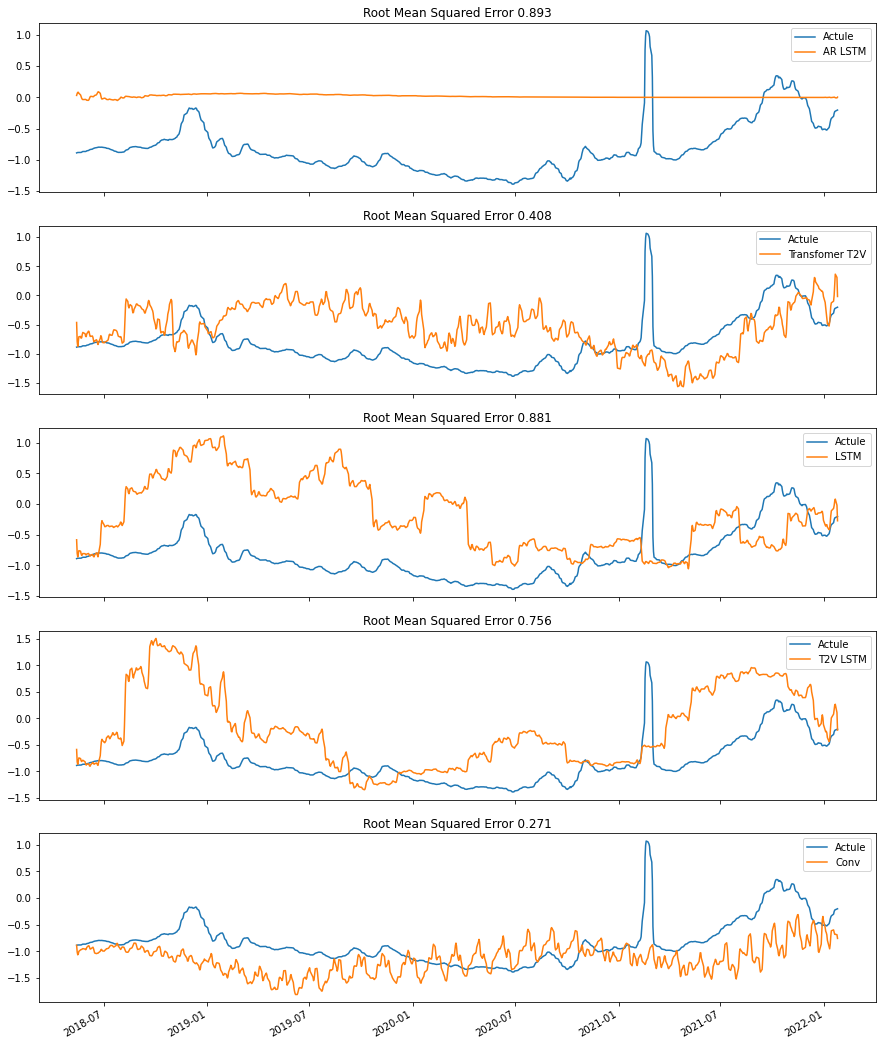

In [ ]:
ops = [
    (yhat_feedback,'AR LSTM'),
    (yhat_transfomer,'Transfomer T2V'),
    (yhat_LSTM,'LSTM'),
    (yhay_T2V,'T2V LSTM'),
    (yhay_conv,'Conv')
]
# plt.figure(figsize=(15,10))
t = date_time[-1*len(decode_y(tempY)):] #.dt.strftime('%d-%b-%Y')
lab = []
fig, ax = plt.subplots(len(ops), 1,figsize=(15,20),sharex='col')
c = 0
for i,j in ops:
    ax[c].plot(t,tempdf['value'][-1*len(decode_y(tempY)):].values)
    ax[c].plot(t,decode_y(i,threshold=9e3))
    rmse = round(mean_squared_error(tempdf['value'][-1*len(decode_y(tempY)):].values,decode_y(i,threshold=9e3)),3)
    ax[c].title.set_text('Root Mean Squared Error '+str(rmse))
    ax[c].legend(['Actule',j])
#     ax[c].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    c+=1
# plt.supxlabel('common x label')
fig.autofmt_xdate()

### Results 🚨

<p><span style="color: #ff6600;"><span style="color: #000000;">As per the performance on latest unseen set the model from best to least can be ranked as&nbsp;</span></span></p>
<ol>
<li><span style="color: #ff6600;"><span style="color: #000000;">CNN 🎉</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">T2V Transformer 🎆</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">T2V LSTM 👏</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">LSTM 🙌</span></span></li>
<li><span style="color: #ff6600;"><span style="color: #000000;">AR-LSTM 👍</span></span></li>
</ol>

30 31
30 31
30 31
30 31
30 31
30 31
30 31


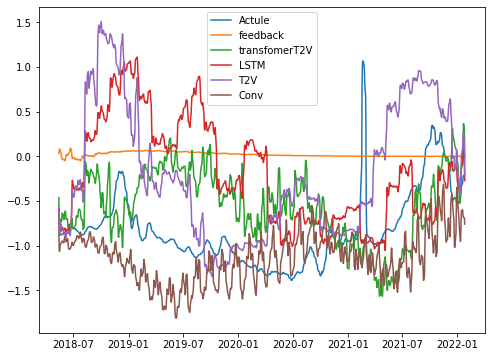

In [ ]:
ops = [
    (yhat_feedback,'feedback'),
    (yhat_transfomer,'transfomerT2V'),
    (yhat_LSTM,'LSTM'),
    (yhay_T2V,'T2V'),
    (yhay_conv,'Conv')
]
t = date_time[-1*len(decode_y(tempY)):]
lab = []

for i,j in ops:
    plt.plot(t,tempdf['value'][-1*len(decode_y(tempY)):].values)
    plt.plot(t,decode_y(i,threshold=9e3))
    lab.append(j)
plt.legend(['Actule']+lab)
plt.show()